In [1]:
import requests
import os
import pandas as pd
import json
import re
import dotenv
import censusdata
# import plotly.express as px
import csv
import geopandas as gpd
import numpy as np
import hvplot.pandas
# import plotly.figure_factory as ff
import plotly.graph_objects as go
from urllib.request import urlopen

dotenv.load_dotenv()
quandl_key = os.getenv('QUANDL_API_KEY')

## 2019 Census Population Data by County
#### Reference: https://www.census.gov/programs-surveys/popest/technical-documentation/file-layouts.html

In [2]:
# read population data
population_df = pd.read_csv(open('co-est2019-alldata.csv'))

# remove results not county
county_df = population_df.loc[population_df['COUNTY'] != 0]

# extract FIPS and set it as index
county_df['FIPS'] = county_df.apply(
    lambda row: str(row['STATE']).zfill(2) + str(row['COUNTY']).zfill(3),
    axis=1
)

county_df.reset_index(inplace=True)
county_df.set_index('FIPS', inplace=True)
county_df.sort_index(inplace=True)
county_df.head()

C:\CustomProgram\anaconda3\envs\pyvizenv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


index  SUMLEV  REGION  DIVISION  STATE  COUNTY   STNAME  \
FIPS                                                             
01001      1      50       3         6      1       1  Alabama   
01003      2      50       3         6      1       3  Alabama   
01005      3      50       3         6      1       5  Alabama   
01007      4      50       3         6      1       7  Alabama   
01009      5      50       3         6      1       9  Alabama   

              CTYNAME  CENSUS2010POP  ESTIMATESBASE2010  ...  \
FIPS                                                     ...   
01001  Autauga County          54571              54597  ...   
01003  Baldwin County         182265             182265  ...   
01005  Barbour County          27457              27455  ...   
01007     Bibb County          22915              22915  ...   
01009   Blount County          57322              57322  ...   

       RDOMESTICMIG2019  RNETMIG2011  RNETMIG2012  RNETMIG2013  RNETMIG2014  \
FIPS                                                                          
01001          4.847310     6.018182    -6.226119    -3.902226     1.970443   
01003         24.017829    16.641870    17.488579    22.751474    20.184334   
01005         -5.690302     0.292676    -6.897817    -8.132185    -5.140431   
01007          1.385134    -4.998356    -3.787545    -5.797999     1.331144   
01009          1.020788     0.208812    -1.650165    -0.347225    -2.049590   

       RNETMIG2015  RNETMIG2016  RNETMIG2017  RNETMIG2018  RNETMIG2019  
FIPS                                                                    
01001    -1.712875     4.777171     0.849656     0.540916     4.560062  
01003    17.725964    21.279291    22.398256    24.727215    24.380567  
01005   -15.724575   -18.238016   -24.998528    -8.754922    -5.165664  
01007     1.329817    -0.708717    -3.234669    -6.857092     1.831952  
01009    -1.338525    -1.391062     6.193562    -0.069229     1.124597  

[5 rows x 165 columns]

## Census TIGER/Line Shapefiles (for Latitude and Longitude)
#### Reference: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html

In [3]:
# read shp file using geopandas
tiger_df = gpd.read_file('../../../Notebooks/tiger_line_data/tl_2019_us_county.shp')

# GEOID = FIPS
tiger_df.set_index('GEOID', inplace=True)
tiger_df.sort_index(inplace=True)
tiger_df.head()

STATEFP COUNTYFP  COUNTYNS     NAME        NAMELSAD LSAD CLASSFP  MTFCC  \
GEOID                                                                           
01001      01      001  00161526  Autauga  Autauga County   06      H1  G4020   
01003      01      003  00161527  Baldwin  Baldwin County   06      H1  G4020   
01005      01      005  00161528  Barbour  Barbour County   06      H1  G4020   
01007      01      007  00161529     Bibb     Bibb County   06      H1  G4020   
01009      01      009  00161530   Blount   Blount County   06      H1  G4020   

      CSAFP CBSAFP METDIVFP FUNCSTAT       ALAND      AWATER     INTPTLAT  \
GEOID                                                                       
01001   388  33860     None        A  1539602137    25706961  +32.5322367   
01003   380  19300     None        A  4117621645  1132980868  +30.6592183   
01005  None  21640     None        A  2292160139    50523213  +31.8702531   
01007   142  13820     None        A  1612167476     9602089  +33.0158929   
01009   142  13820     None        A  1670103866    15015467  +33.9773575   

           INTPTLON                                           geometry  
GEOID                                                                   
01001  -086.6464395  POLYGON ((-86.90310 32.54063, -86.90311 32.540...  
01003  -087.7460666  POLYGON ((-87.99068 30.55549, -87.99051 30.560...  
01005  -085.4051035  POLYGON ((-85.42982 32.04598, -85.42985 32.046...  
01007  -087.1271475  POLYGON ((-87.31226 33.08622, -87.31218 33.087...  
01009  -086.5664400  POLYGON ((-86.74919 33.99760, -86.74902 33.997...

## Population Density Data Visualization
#### by combining Tiger/Line Land Area and Total Population Data

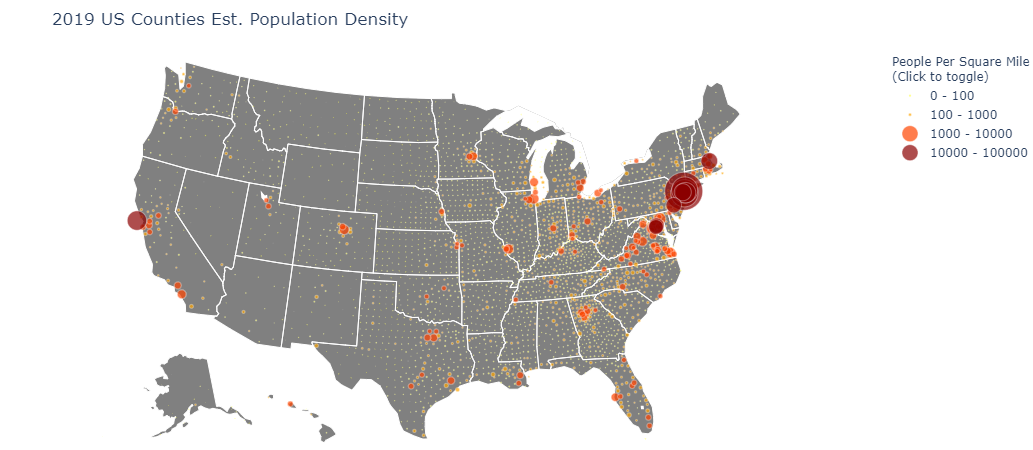

index  SUMLEV  REGION  DIVISION  STATE  COUNTY                STNAME  \
36061   1891      50       1         2     36      61              New York   
36047   1884      50       1         2     36      47              New York   
36005   1863      50       1         2     36       5              New York   
36081   1901      50       1         2     36      81              New York   
06075    228      50       4         9      6      75            California   
34017   1813      50       1         2     34      17            New Jersey   
25025   1251      50       1         1     25      25         Massachusetts   
42101   2333      50       1         2     42     101          Pennsylvania   
11001    328      50       3         5     11       1  District of Columbia   
51510   2962      50       3         5     51     510              Virginia   

                    CTYNAME  CENSUS2010POP  ESTIMATESBASE2010  ...  FUNCSTAT  \
36061       New York County        1585873            1586381  ...         C   
36047          Kings County        2504700            2504721  ...         C   
36005          Bronx County        1385108            1384580  ...         C   
36081         Queens County        2230722            2230619  ...         C   
06075  San Francisco County         805235             805184  ...         C   
34017         Hudson County         634266             634284  ...         A   
25025        Suffolk County         722023             722183  ...         N   
42101   Philadelphia County        1526006            1526012  ...         C   
11001  District of Columbia         601723             601767  ...         F   
51510       Alexandria city         139966             139998  ...         F   

           ALAND     AWATER     INTPTLAT      INTPTLON  \
36061   58690498   28541727  +40.7766419  -073.9701871   
36047  179671310   71098973  +40.6350451  -073.9506398   
36005  108909571   39687923  +40.8487111  -073.8529390   
36081  281734463  179364919  +40.6585662  -073.8380168   
06075  121477743  479114582  +37.7272391  -123.0322294   
34017  119640830   41958705  +40.7313751  -074.0786014   
25025  150863059  160514693  +42.3385513  -071.0182530   
42101  347781835   21806065  +40.0093755  -075.1333459   
11001  158340389   18687196  +38.9042474  -077.0165167   
51510   38679383    1070216  +38.8192511  -077.0836695   

                                                geometry  population_density  \
36061  MULTIPOLYGON (((-74.03294 40.68778, -74.02628 ...        71874.171308   
36047  POLYGON ((-74.05647 40.63171, -74.05626 40.637...        36901.389855   
36005  POLYGON ((-73.93365 40.88246, -73.93173 40.885...        33726.519557   
36081  POLYGON ((-74.03813 40.53829, -74.03749 40.542...        20719.750638   
06075  MULTIPOLYGON (((-122.61228 37.81522, -122.5845...        18795.232030   
34017  POLYGON ((-74.09079 40.76198, -74.09027 40.761...        14555.945580   
25025  POLYGON ((-71.03318 42.41421, -71.03301 42.414...        13801.327115   
42101  POLYGON ((-75.28027 39.97496, -75.27951 39.975...        11796.788095   
11001  POLYGON ((-77.11975 38.93435, -77.11886 38.935...        11544.005171   
51510  POLYGON ((-77.14436 38.81036, -77.14397 38.810...        10675.371787   

             lat         lon                                           text  
36061  40.776642  -73.970187       New York County<br>71874 Per Square Mile  
36047  40.635045  -73.950640          Kings County<br>36901 Per Square Mile  
36005  40.848711  -73.852939          Bronx County<br>33727 Per Square Mile  
36081  40.658566  -73.838017         Queens County<br>20720 Per Square Mile  
06075  37.727239 -123.032229  San Francisco County<br>18795 Per Square Mile  
34017  40.731375  -74.078601         Hudson County<br>14556 Per Square Mile  
25025  42.338551  -71.018253        Suffolk County<br>13801 Per Square Mile  
42101  40.009375  -75.133346   Philadelphia County<br>11797 Per Square Mile  
11001  38.904247  -77.016517  Dist

In [57]:
density_df = pd.concat(
    [county_df, tiger_df],
    join = 'inner',
    axis = 1
)

# ALAND = sq. km; * 0.386102 to get sq. miles
density_df['population_density'] = (
    density_df['POPESTIMATE2019'] /
    density_df['ALAND'].apply(lambda x: x * 0.386102) * 1000000
)
density_df['lat'] = density_df['INTPTLAT'].apply(lambda x: float(x))
density_df['lon'] = density_df['INTPTLON'].apply(lambda x: float(x))

density_df.sort_values('population_density', ascending=False, inplace=True)

colors = ['darkred', 'orangered', 'orange', 'yellow']
limits = [(100000, 10000), (10000, 1000), (1000, 100), (100, 0)]
density_df['text'] = density_df['CTYNAME'] + '<br>' + (density_df['population_density'].apply(lambda x: round(x))).astype(str)+' Per Square Mile'

pop_density_fig = go.Figure()

for i in reversed(range(len(limits))):
    lim = limits[i]
    df_sub = density_df.loc[(density_df['population_density'] < lim[0]) & (density_df['population_density'] > lim[1])]
    pop_density_fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lat = df_sub['lat'],
        lon = df_sub['lon'],
        text = df_sub['text'],
        marker = dict(
            size = df_sub['population_density']/100,
            color = colors[i],
            line_color = 'white',
            line_width = 0.5,
            sizemode = 'area'
        ),
        name = '{1} - {0}'.format(lim[0],lim[1])
    ))

pop_density_fig.update_layout(
    title_text = '2019 US Counties Est. Population Density',
    legend_title = 'People Per Square Mile<br>(Click to toggle)',
    showlegend = True,
    geo = dict(
        scope = 'usa',
        landcolor = 'gray',
    ),
    margin={'r': 0, 't': 50, 'l': 0, 'b': 0}
)
pop_density_fig.show()
density_df.head(10)

## CensusData Python Library
#### (for obtaining Median Home Value/Median Real Estate Tax) reference: https://pypi.org/project/CensusData/

In [5]:
# census api
census_key = os.getenv('CENSUS_API_KEY')

# https://jtleider.github.io/censusdata

# define dataset
dataset = {
    'B25077_001E': 'Median Home Value',
    'B25103_001E': 'Median Real Estate Tax',
    'B25121_001E': 'Median Household Income'
}
census_df = pd.DataFrame()

# download census data while concating data horizontally (2018 is the last year of data available)
for year in range(2012, 2019):
    data = censusdata.download(
        'acs5',
        year,
        censusdata.censusgeo([('county', '*')]),
        list(dataset.keys())
    )
    data['year'] = year
    data
    new_indices = []
    county_names = []
    for index in data.index.tolist():
        new_index = index.geo[0][1] + index.geo[1][1]
        new_indices.append(new_index)
        county_name = index.name.split(':')[0]
        county_names.append(county_name)
    data.index = new_indices
    data['county_name'] = county_names
    data.rename(dataset)
    census_df = pd.concat([census_df, data], axis=0)

census_df.rename(columns=dataset, inplace=True)
census_df['Real Estate Tax Rate'] = census_df['Median Real Estate Tax'] / census_df['Median Home Value']

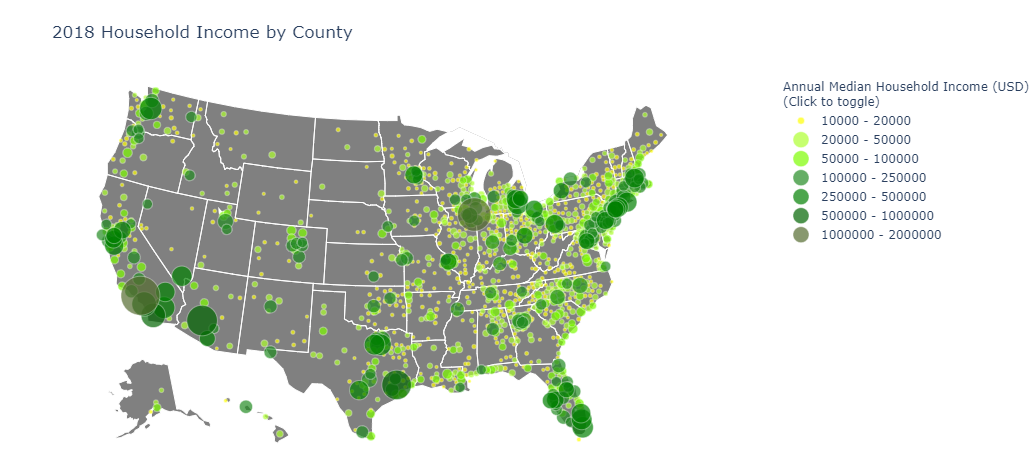

Median Home Value  Median Real Estate Tax  Median Household Income  \
06037           543400.0                  3938.0                1514629.0   
17031           237200.0                  4984.0                1116759.0   
04013           242700.0                  1489.0                 933112.0   
48201           165300.0                  3356.0                 865645.0   
06073           526300.0                  3868.0                 593890.0   

       year                     county_name  Real Estate Tax Rate STATEFP  \
06037  2018  Los Angeles County, California              0.007247      06   
17031  2018           Cook County, Illinois              0.021012      17   
04013  2018        Maricopa County, Arizona              0.006135      04   
48201  2018            Harris County, Texas              0.020302      48   
06073  2018    San Diego County, California              0.007349      06   

      COUNTYFP  COUNTYNS         NAME  ... METDIVFP FUNCSTAT        ALAND  \
06037      037  00277283  Los Angeles  ...    31084        A  10511861492   
17031      031  01784766         Cook  ...    16984        A   2447357982   
04013      013  00037026     Maricopa  ...     None        A  23829622328   
48201      201  01383886       Harris  ...     None        A   4418909573   
06073      073  00277301    San Diego  ...     None        A  10904373558   

           AWATER     INTPTLAT      INTPTLON  \
06037  1793485467  +34.1963983  -118.2618616   
17031  1786325586  +41.8942937  -087.6454546   
04013    63347750  +33.3451756  -112.4989297   
48201   184757689  +29.8572730  -095.3930371   
06073   817404622  +33.0236041  -116.7761174   

                                                geometry        lat  \
06037  MULTIPOLYGON (((-118.70339 34.16859, -118.7033...  34.196398   
17031  POLYGON ((-88.23819 42.06698, -88.23819 42.067...  41.894294   
04013  POLYGON ((-112.27604 33.88231, -112.27667 33.8...  33.345176   
48201  POLYGON ((-95.85685 29.87458, -95.85686 29.874...  29.857273   
06073  POLYGON ((-117.43743 33.17953, -117.44954 33.1...  33.023604   

              lon                                               text  
06037 -118.261862  Los Angeles County, California<br>Median House...  
17031  -87.645455  Cook County, Illinois<br>Median Household Inco...  
04013 -112.498930  Maricopa County, Arizona<br>Median Household I...  
48201  -95.393037  Harris County, Texas<br>Median Household Incom...  
06073 -116.776117  San Diego County, California<br>Median Househo...  

[5 rows x 26 columns]

In [55]:
income_df = pd.concat(
    [census_df.loc[census_df['year'] == 2018], tiger_df],
    join = 'inner',
    axis = 1
)

income_df['lat'] = density_df['INTPTLAT'].apply(lambda x: float(x))
income_df['lon'] = density_df['INTPTLON'].apply(lambda x: float(x))

income_df.sort_values('Median Household Income', ascending=False, inplace=True)
colors = ['darkolivegreen', 'darkgreen', 'green', 'forestgreen', 'lawngreen', 'greenyellow', 'yellow']
limits = [(2000000, 1000000), (1000000, 500000), (500000, 250000), (250000, 100000), (100000, 50000), (50000, 20000), (20000, 10000)]
income_df['text'] = income_df['county_name'] + '<br>Median Household Income ' + (income_df['Median Household Income'].apply(lambda x: "${:.1f}K".format(x/1000))).astype(str)

income_fig = go.Figure()

for i in reversed(range(len(limits))):
    lim = limits[i]
    income_sub = income_df.loc[(income_df['Median Household Income'] < lim[0]) & (income_df['Median Household Income'] > lim[1])]
    income_fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lat = income_sub['lat'],
        lon = income_sub['lon'],
        text = income_sub['text'],
        marker = dict(
            size = income_sub['Median Household Income']/2000,
            color = colors[i],
            line_color = 'white',
            line_width = 0.5,
            sizemode = 'area'
        ),
        name = '{1} - {0}'.format(lim[0],lim[1])
    ))

income_fig.update_layout(
    title_text = '2018 Household Income by County',
    legend_title = 'Annual Median Household Income (USD)<br>(Click to toggle)',
    showlegend = True,
    geo = dict(
        scope = 'usa',
        landcolor = 'gray',
    ),
    margin={"r":0,"t":75,"l":0,"b":0}
)
income_fig.show()
income_df.head(10)

## Fetching Zillow Dataset through QUANDL
#### Obtaining both Median Home Value and Price-to-Rent Ratio
#### Focusing on the Counties with both Top 100 Income (Affordability) and Top 100 Population Density (Demand)

In [8]:
# Reference Quandl Zillow Research Documentation
# https://www.quandl.com/data/ZILLOW-Zillow-Real-Estate-Research/documentation

# function for calling quandl zillow api
def fetch_zillow_quandl(quandl_code, quandl_key):
    url = f'https://www.quandl.com/api/v3/datasets/ZILLOW/{quandl_code}?start_date=2012-01-01&end_date=2018-12-31&api_key={quandl_key}'
    response = json.loads(
        requests.get(url).content
    )
    return response['dataset']['data'] if response['dataset'] else None

# State = S
# County = CO
# Greater Metropolitan Area = M
# City = C
# Neighborhood = N
# Zip Code = Z

def zillow_codes(path, delimiter):
    csv_data = csv.DictReader(open(path), delimiter=delimiter)
    return list(map(lambda x: dict(x), csv_data))

In [9]:
city_lookup = zillow_codes('Quandl_Zillow_Research/city.txt', '|')
county_lookup = zillow_codes('Quandl_Zillow_Research/county.txt', '|')
metro_lookup = zillow_codes('Quandl_Zillow_Research/metro.txt', '|')
state_lookup = zillow_codes('Quandl_Zillow_Research/state.txt', '|')
indicators_lookup = zillow_codes('Quandl_Zillow_Research/indicators.csv', '|')

In [10]:
def match_locale_name(ctyname, lookup):
    ctyname = ctyname.lower().replace('st. ', 'saint ').replace("'s", '')
    matched_list = list(filter(lambda x: ctyname in x['AREA'].lower(), lookup))
    return f"CO{matched_list[0]['CODE']}" if matched_list else None
#     return matched_list[0] if matched_list else None

In [72]:
density_df['zcode'] = density_df['CTYNAME'].apply(
    lambda x: match_locale_name(x, county_lookup)
)

In [74]:
top_100_county = pd.concat([income_df[:100], density_df[:100]], join='inner', axis=1)

In [75]:
select_indicators = ['MVALFAH', 'PRRAH']

for indicator in select_indicators:
    top_100_county[indicator] = top_100_county['zcode'].apply(
        lambda x: fetch_zillow_quandl(f'{x}_{indicator}', quandl_key)
    )

In [93]:
def housing_plot(top_100_county):
    
    import panel as pn
    from panel.interact import interact
    pn.extension()

    def county_plot(County='New York County, New York'):
        mvalfah_headers = ['date', 'value']
        mvalfah = pd.DataFrame(list(top_100_county.loc[top_100_county['CTYNAME'] == County.split(', ')[0]]['MVALFAH'].to_list()[0]), columns=mvalfah_headers)
        mvalfah['date'] = mvalfah['date'].astype('datetime64[ns]')
        mvalfah.set_index('date', inplace = True)
        mvalfah.sort_index(inplace = True)
        
        prrah_headers = ['date', 'ratio']
        prrah = pd.DataFrame(list(top_100_county.loc[top_100_county['CTYNAME'] == County.split(', ')[0]]['PRRAH'].to_list()[0]), columns=prrah_headers)
        prrah['date'] = prrah['date'].astype('datetime64[ns]')
        prrah.set_index('date', inplace = True)
        prrah.sort_index(inplace = True)
        
        mvalfah_plot = mvalfah.hvplot.line(
            x = 'date',
            xlabel = 'Date',
            y = 'value',
            yaxis = 'left',
            ylabel = 'Per Square Foot (USD)',
            title = 'Median Home Value',
            width = 500
        )
        
        prrah_plot = prrah.hvplot.line(
            x = 'date',
            xlabel = 'Date',
            y = 'ratio',
            yaxis = 'right',
            ylabel = 'Home Price / Annual Rent',
            title = 'Price to Rent Ratio',
            width = 500
        )
        
        return mvalfah_plot + prrah_plot

    return interact(county_plot, County=sorted(list(top_100_county['CTYNAME'] + ', ' + top_100_county['STNAME'])))

In [94]:
# top_100_county.loc[top_100_county['CTYNAME'] == 'San Francisco County']['MVALFAH'].to_list()[0]
housing_plot(top_100_county)

Column
    [0] Column
        [0] Select(name='County', options=['Alameda County, ...], value='New York County, ...)
    [1] Row
        [0] HoloViews(Layout, name='interactive24996')

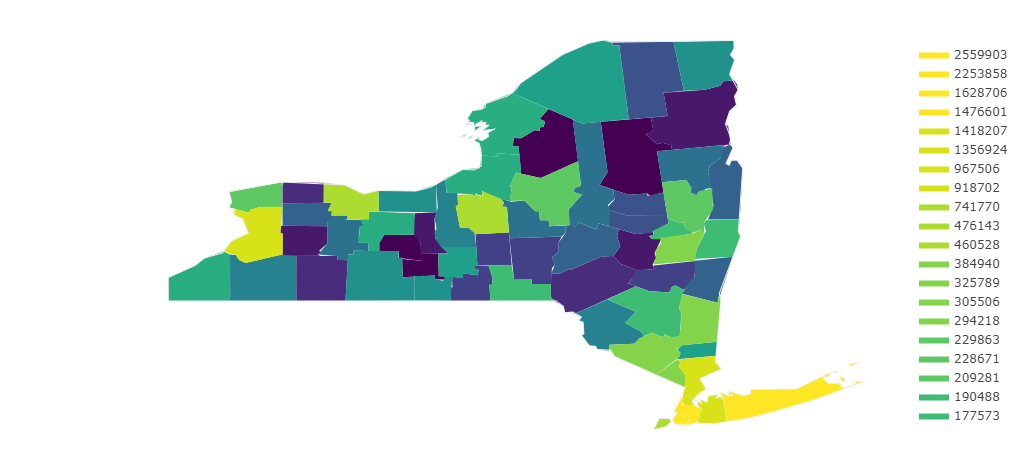

In [86]:
import plotly.figure_factory as ff

fips = list(density_df[density_df['STNAME'] == 'New York'].index)
values =  list(density_df[density_df['STNAME'] == 'New York']['POPESTIMATE2019'])

fig = ff.create_choropleth(
    fips=fips,
    values=values,
    scope=['New York']
)
fig.layout.template = None
fig.show()

## Getting Neighhorhood Geographical Data
#### Reference: https://data.opendatasoft.com/explore/dataset/zillow-neighborhoods%40public/export/

In [134]:
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
%matplotlib inline

mapbox_token = os.getenv('MAPBOX_API_KEY')

# neighborhood_df = gpd.read_file('zillow_neighborhods/zillow-neighborhoods.shp')
geo_df = gpd.read_file('zillow-neighborhoods.geojson')
# geo_df
geo_fig = go.Figure(
    go.Choroplethmapbox(
        geojson=geo_df,
        locations=geo_df['regionid'],
        z=geo_df['POPESTIMATE2019'],
        colorscale='Cividis',
        zmin=0,
        zmax=17,
        marker_line_width=3
    )
)

geo_fig.update_layout(mapbox_style='carto-positron')
geo_fig

KeyError: 'POPESTIMATE2019'

In [130]:
india_state_link = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vSAD0SPvZSXA6TWBih-uaKutfl-m_UewVBqozY-kk3HudlM-23Iput1XiRrzd8VopiQXvK5KoN5_Sl3/pub?output=csv'
india_state = pd.read_csv(india_state_link)
india_state = india_state.dropna(axis = 1, how = 'all') #dropping NaN columns
india_state = india_state.dropna(axis = 0, how = 'all') ##dropping NaN rows
india_state = india_state.dropna()
col = india_state.columns
india_state = india_state.rename(columns = {col[1]: 'State', col[2]:'confirmed', col[3]:'cured', col[4]:'death', col[5]:'Latitude', col[6]:'Longitude'})
india_state = india_state.dropna()
india_state = india_state.astype({'confirmed': 'float64', 'cured':'float64', 'death':'float64'})

#reading json
with open('india-states.json', encoding = 'utf8') as f:
    india = json.loads(f.read())

id_dict = {}
for i in range(35):
    name = india['objects']['IND_adm1']['geometries'][i]['properties']['NAME_1']
    id_geojson = india['objects']['IND_adm1']['geometries'][i]['properties']['id']
    id_dict[name] = id_geojson

india_state['id_map'] = india_state['State'].map(id_dict)
india_state  = india_state.fillna(0)
india_state = india_state.astype({'id_map':'int'})

#plotting the map
fig = go.Figure(go.Choroplethmapbox(geojson=india,locations=india_state.id_map,z=india_state.confirmed,
                                    colorscale='Cividis',zmin=0,zmax=17,
                                    marker_line_width=3))

fig.update_layout(mapbox_style="carto-positron")

ValueError: could not convert string to float: '1,49,520'

In [21]:
from pytrends.request import TrendReq
import time
startTime = time.time()
pytrend = TrendReq(hl='en-US', tz=360)
pytrend.build_payload(kw_list=['POTUS'])
df = pytrend.interest_by_region()
df.loc[df['POTUS'] != 0].sort_values(by='POTUS', ascending=False)

POTUS
geoName                    
Argentina               100
United States            79
Canada                   56
Uruguay                  53
Singapore                37
Australia                37
New Zealand              34
Kenya                    33
Ireland                  30
India                    28
Norway                   26
United Kingdom           26
Italy                    25
Finland                  25
Nigeria                  24
Bangladesh               23
Denmark                  22
Sweden                   21
Spain                    20
Netherlands              20
Switzerland              19
United Arab Emirates     18
Pakistan                 17
Austria                  16
South Africa             16
Hong Kong                16
Germany                  16
Belgium                  15
Philippines              15
Malaysia                 12
Mexico                   12
Chile                    11
Israel                   11
Portugal                 10
Colombia                  7
Romania                   7
France                    7
Venezuela                 7
Peru                      7
Greece                    7
Poland                    5
Taiwan                    4
Indonesia                 4
Thailand                  3
Turkey                    3
Brazil                    3
Japan                     2
Russia                    2
Vietnam                   2

In [33]:
# kaggle https://github.com/Kaggle/kaggle-api#api-credentials